
Imports e definição do dataset.

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

from tensorflow import keras
from tensorflow.keras import layers, models

Função para carregamento dos datasets

In [2]:
def load_dataset(name):
    """
    Carrega e pré-processa o dataset especificado.
    name: "mnist", "fashion_mnist", "cifar10" ou "cifar100"
    Retorna: (x_train, y_train), (x_test, y_test), num_classes
    """
    if name == "mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = x_train[..., None].astype("float32") / 255.0
        x_test = x_test[..., None].astype("float32") / 255.0
        num_classes = 10

    elif name == "fashion_mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
        x_train = x_train[..., None].astype("float32") / 255.0
        x_test = x_test[..., None].astype("float32") / 255.0
        num_classes = 10

    elif name == "cifar10":
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        x_train = x_train.astype("float32") / 255.0
        x_test = x_test.astype("float32") / 255.0
        y_train, y_test = y_train.ravel(), y_test.ravel()
        num_classes = 10

    elif name == "cifar100":
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
        x_train = x_train.astype("float32") / 255.0
        x_test = x_test.astype("float32") / 255.0
        y_train, y_test = y_train.ravel(), y_test.ravel()
        num_classes = 100

    else:
        raise ValueError(f"Dataset {name} não suportado")

    return (x_train, y_train), (x_test, y_test), num_classes

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


O código abaixo mostra as 10 primeiras imagens de treino e teste dos datasets

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


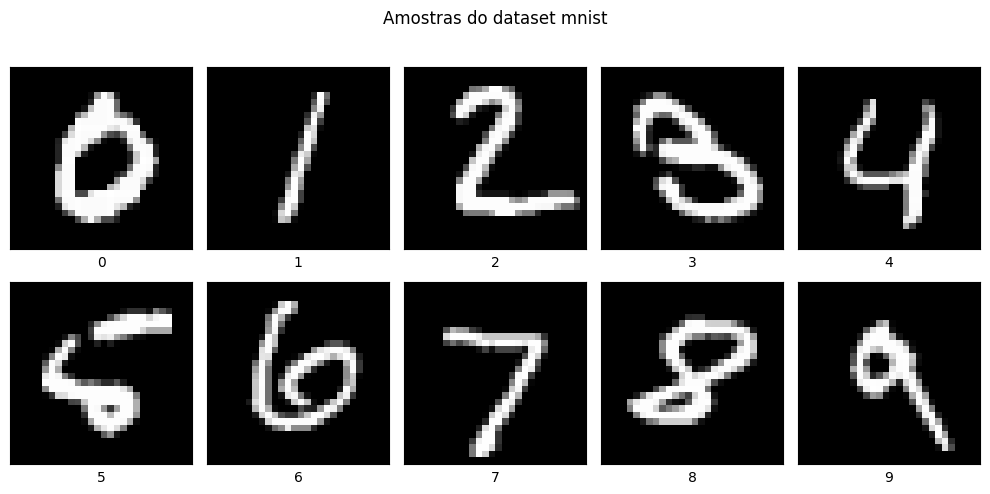

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


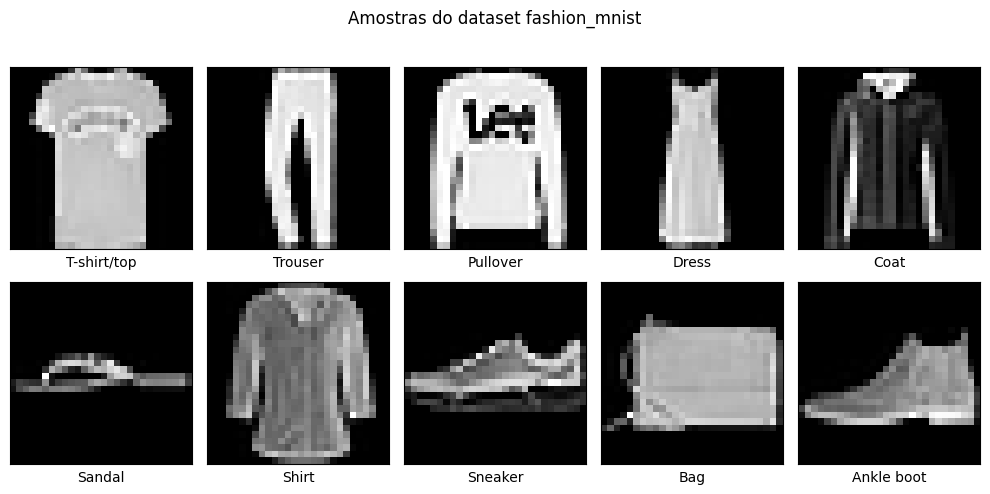

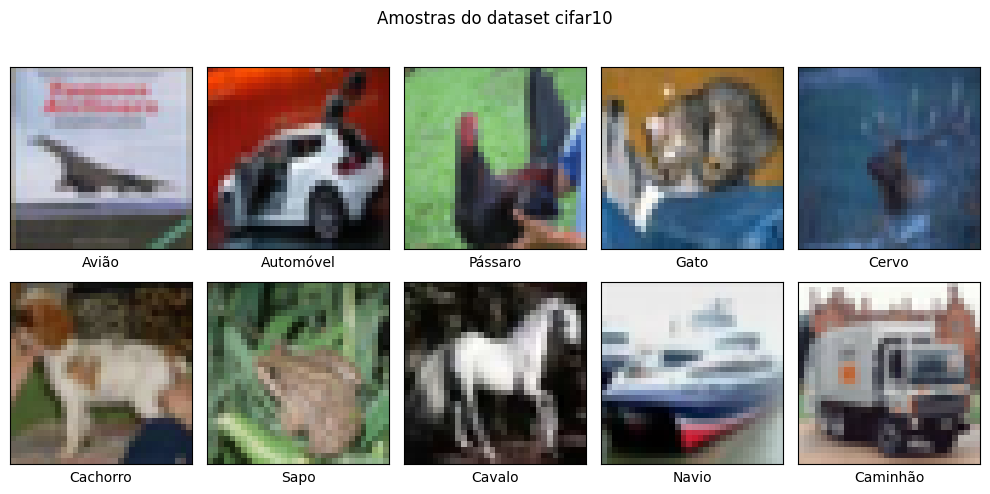

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


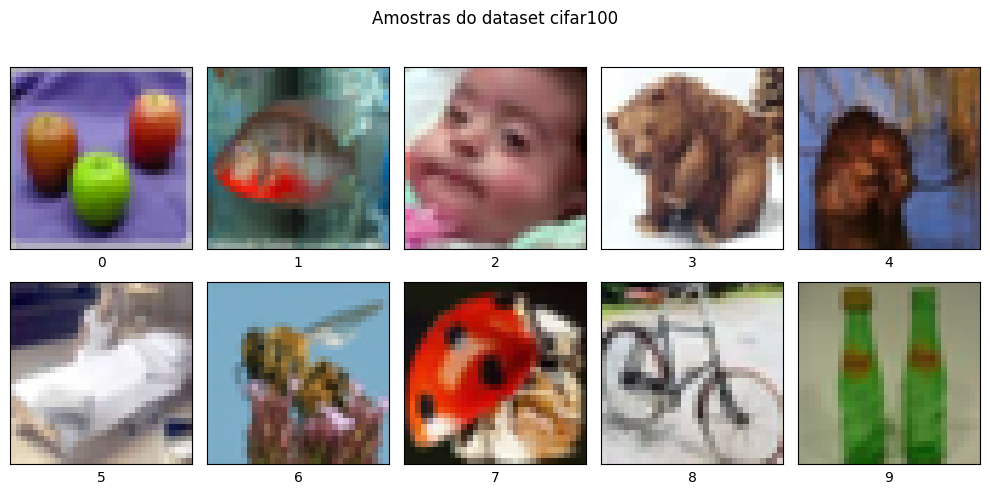

In [3]:
class_names = {
    "mnist": [str(i) for i in range(10)],
    "fashion_mnist": [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ],
    "cifar10": [
        'Avião', 'Automóvel', 'Pássaro', 'Gato', 'Cervo',
        'Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão'
    ],
    # Para CIFAR-100 existem 100 classes; para não poluir, vamos mostrar apenas os índices
    "cifar100": None
}

def plot_sample_images(x, y, dataset_name, num_classes=10):
    """
    Plota uma amostra de imagens (1 por classe, até 10 classes).
    Para CIFAR-100, mostra as 10 primeiras classes encontradas no conjunto.
    """
    labels = class_names.get(dataset_name, None)

    unique_classes = np.unique(y)
    selected_classes = unique_classes[:min(10, len(unique_classes))]

    images = []
    for c in selected_classes:
        idx = np.where(y == c)[0][0]
        images.append((x[idx], c))

    plt.figure(figsize=(10, 5))
    for i, (img, label) in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.xticks([]); plt.yticks([])
        if img.shape[-1] == 1:  # grayscale (MNIST, Fashion-MNIST)
            plt.imshow(img.squeeze(), cmap="gray")
        else:                   # colorido (CIFAR-10, CIFAR-100)
            plt.imshow(img)
        if labels:
            plt.xlabel(labels[label])
        else:
            plt.xlabel(str(label))
    plt.suptitle(f"Amostras do dataset {dataset_name}")
    plt.tight_layout()
    plt.show()

(x_train, y_train), (x_test, y_test), num_classes = load_dataset("mnist")
plot_sample_images(x_test, y_test, "mnist", num_classes)

(x_train, y_train), (x_test, y_test), num_classes = load_dataset("fashion_mnist")
plot_sample_images(x_test, y_test, "fashion_mnist", num_classes)

(x_train, y_train), (x_test, y_test), num_classes = load_dataset("cifar10")
plot_sample_images(x_test, y_test, "cifar10", num_classes)

(x_train, y_train), (x_test, y_test), num_classes = load_dataset("cifar100")
plot_sample_images(x_test, y_test, "cifar100", num_classes)


Abaixo, convertemos os rótulos escalares (números de 0 a 9) para one-hot encoding.

Não é necessário realizar este passo, caso seja utilizada a função de custo esparse_categorical_cross_entropy

In [ ]:
# Converter para codificação one-hot dos labels
# train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
# test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
#Não é necessário se utilizar como função de custo esparse_categorical_cross_entropy

Função que constrói uma rede neural genérica

In [4]:
def build_network(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Trecho para treinar e avaliar a rede neural.
O treino é realizado com os dados de treino e a avaliação do modelo é realizada nos dados de teste.

In [5]:
model = build_network(train_images.shape[1:], num_classes)

x_val, y_val = train_images[:5000], train_labels[:5000]
x_train, y_train = train_images[5000:], train_labels[5000:]

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.3167 - loss: 2.0402 - val_accuracy: 0.4994 - val_loss: 1.4085
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.5136 - loss: 1.3790 - val_accuracy: 0.5580 - val_loss: 1.2686
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 77s 104ms/step - accuracy: 0.5616 - loss: 1.2594 - val_accuracy: 0.5694 - val_loss: 1.2333
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.5949 - loss: 1.1692 - val_accuracy: 0.5974 - val_loss: 1.1473
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.6177 - loss: 1.0987 - val_accuracy: 0.6110 - val_loss: 1.1326
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.6356 - loss: 1.0580 - val_accuracy: 0.5988 - val_loss: 1.1286
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.6472 - loss: 1.0086 - val_accuracy: 0.6268 - val_loss: 1.0740
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.6671 - loss: 0.

# Na célula abaixo, adicione o código para carregar os demais datasets

In [7]:
datasets = {}

for name in ["mnist", "fashion_mnist", "cifar10", "cifar100"]:
    (train_images, train_labels), (test_images, test_labels), num_classes = load_dataset(name)
    datasets[name] = {
        "train_images": train_images,
        "train_labels": train_labels,
        "test_images": test_images,
        "test_labels": test_labels,
        "num_classes": num_classes
    }
    print(f"{name} carregado: {train_images.shape[0]} imagens de treino, {test_images.shape[0]} imagens de teste, {num_classes} classes.")


mnist carregado: 60000 imagens de treino, 10000 imagens de teste, 10 classes.
fashion_mnist carregado: 60000 imagens de treino, 10000 imagens de teste, 10 classes.
cifar10 carregado: 50000 imagens de treino, 10000 imagens de teste, 10 classes.
cifar100 carregado: 50000 imagens de treino, 10000 imagens de teste, 100 classes.


Tarefa
Escreva código para executar redes neurais nos seguintes datasets:

MNIST (pode aproveitar o codigo existente)
Fashion MNIST
CIFAR-10
CIFAR-100
Cada execução deve ser por 10 épocas.

Você deve preencher as funções a seguir para retornarem a rede neural com a melhor configuração que você conseguiu para cada dataset. O notebook deve ser entregue com a rede neural que obteve a melhor performance em cada conjunto de dados.

IMPORTANTE: as funções não devem TREINAR nem AVALIAR as redes neurais, apenas instanciá-las e retorná-las.

Ao final, preencha o dict results com o desempenho encontrado em cada execução.

In [8]:
def get_mnist_network():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_fashion_mnist_network():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),  # um pouco de regularização
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_cifar10_network():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_cifar100_network():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(100, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Preencha o dict abaixo substituindo os None com a acuracia final (acc) e o tempo de treinamento (time) encontrado no seu experimento pra cada dataset

In [9]:
results = {}

networks = {
    "mnist": get_mnist_network,
    "fashion_mnist": get_fashion_mnist_network,
    "cifar10": get_cifar10_network,
    "cifar100": get_cifar100_network
}

for name, net_fn in networks.items():
    print(f"\n=== Treinando {name.upper()} ===")

    (train_images, train_labels), (test_images, test_labels), num_classes = load_dataset(name)

    model = net_fn()

    start = time.time()
    history = model.fit(train_images, train_labels,
                        epochs=10, batch_size=128, verbose=1)
    end = time.time()

    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

    results[name] = {
        "time": end - start,
        "acc": float(test_acc)
    }

print("\nResultados finais:")
print(results)


results = {
   'mnist': {'time': 793.8806674480438, 'acc': 0.9900000095367432},
   'fashion_mnist': {'time': 786.7452416419983, 'acc': 0.9228000044822693},
   'cifar10': {'time': 3038.2692494392395, 'acc': 0.7656999826431274},
   'cifar100': {'time': 10269.694934368134, 'acc': 0.4510999917984009}
}



=== Treinando MNIST ===
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 149ms/step - accuracy: 0.8696 - loss: 0.4567
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - accuracy: 0.9833 - loss: 0.0530
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.9897 - loss: 0.0345
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.9918 - loss: 0.0264
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - accuracy: 0.9932 - loss: 0.0216
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.9957 - loss: 0.0140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 146ms/step - accuracy: 0.9969 - loss: 0.0107
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.9968 - loss: 0.0101
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step - accuracy: 0.9969 - loss: 0.0092
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - accuracy: 0.9981 - loss: 0.0059

=== Treinando FASHION_MNIST ===
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 150ms/s